# EfficientNet Model Training

This notebook contains model training process for EfficientNet model on three different deepfake detection datasets. The model training splitted into two parts, which are baseline model (base model without dropout) and the dropout model itself.

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB7, efficientnet
import tensorflow as tf
import keras_tuner as kt
import matplotlib.pyplot as plt
import pickle
import os

## Define Dataset Directory

In [2]:
CDF_DATASET_DIR = "/kaggle/input/deepfake-detection-datasets/Celeb-DF-v2"
DF_DATASET_DIR = "/kaggle/input/deepfake-detection-datasets/DeeperForensics-1.0"
DFDC_DATASET_DIR = "/kaggle/input/deepfake-detection-datasets/DFDC"

In [3]:
cdf_train_dir = os.path.join(CDF_DATASET_DIR, "Train")
cdf_val_dir = os.path.join(CDF_DATASET_DIR, "Val")

df_train_dir = os.path.join(DF_DATASET_DIR, "Train")
df_val_dir = os.path.join(DF_DATASET_DIR, "Val")

dfdc_train_dir = os.path.join(DFDC_DATASET_DIR, "Train")
dfdc_val_dir = os.path.join(DFDC_DATASET_DIR, "Val")

## Image Data Generator for Each Dataset

In [4]:
def create_image_generator(dataset_dir):
    datagen = ImageDataGenerator(preprocessing_function=efficientnet.preprocess_input)
    image_generator = datagen.flow_from_directory(
        dataset_dir,
        target_size=(128, 128),
        batch_size=32,
        color_mode="rgb",
        class_mode="binary",
        shuffle=True,
        seed=42
    )

    return image_generator

In [5]:
print("Celeb-DF-v2 Dataset")
cdf_train_generator = create_image_generator(cdf_train_dir)
cdf_val_generator = create_image_generator(cdf_val_dir)

print("\nDeeperForensics-1.0 Dataset")
df_train_generator = create_image_generator(df_train_dir)
df_val_generator = create_image_generator(df_val_dir)

print("\nDeepfake Detection Challenge Dataset")
dfdc_train_generator = create_image_generator(dfdc_train_dir)
dfdc_val_generator = create_image_generator(dfdc_val_dir)

Celeb-DF-v2 Dataset
Found 14000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.

DeeperForensics-1.0 Dataset
Found 14000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.

Deepfake Detection Challenge Dataset
Found 14000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


## Get the Best Hyperparameters from Tuner

In [6]:
TUNER_RESULT_DIR = "/kaggle/input/hyperparameter-tuning/tuner_result"
BASE_HP_TUNER_PROJECT_NAME = "base_hp"
DROPOUT_TUNER_PROJECT_NAME = "dropout_rate"

In [7]:
def get_best_hp_from_tuner(tuner_dir, project_name):
    tuner = kt.Hyperband(directory=tuner_dir,
                         project_name=project_name,
                         overwrite=False)

    best_hp = tuner.get_best_hyperparameters()[0].values
    return best_hp

### Base Hyperparameters

In [8]:
best_base_hp = get_best_hp_from_tuner(TUNER_RESULT_DIR, BASE_HP_TUNER_PROJECT_NAME)
best_base_hp

Reloading Tuner from /kaggle/input/hyperparameter-tuning/tuner_result/base_hp/tuner0.json


{'conv_layers': 4,
 'conv_1_filters': 256,
 'conv_2_filters': 224,
 'conv_3_filters': 256,
 'conv_1_kernel_size': 3,
 'conv_2_kernel_size': 3,
 'conv_3_kernel_size': 3,
 'dense_layers': 4,
 'dense_1_layer_units': 64,
 'dense_2_layer_units': 224,
 'learning_rate': 1e-05,
 'conv_4_filters': 256,
 'conv_4_kernel_size': 7,
 'dense_3_layer_units': 224,
 'dense_4_layer_units': 224,
 'dense_5_layer_units': 224,
 'conv_5_filters': 192,
 'conv_5_kernel_size': 3,
 'tuner/epochs': 20,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 0,
 'tuner/round': 0}

### Dropout Hyperparameter

In [9]:
best_dropout_hp = get_best_hp_from_tuner(TUNER_RESULT_DIR, DROPOUT_TUNER_PROJECT_NAME)
best_dropout_hp

Reloading Tuner from /kaggle/input/hyperparameter-tuning/tuner_result/dropout_rate/tuner0.json


{'dropout_rate': 0.65,
 'tuner/epochs': 3,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 2,
 'tuner/round': 0}

### Combine All Hyperparameters into a Dict

In [10]:
best_hp = {}

best_hp["conv_layers"] = best_base_hp.get("conv_layers")
for i in range(best_base_hp.get("conv_layers")):
    conv_filter_hp_name = f"conv_{i+1}_filters"
    conv_kernel_size_hp_name = f"conv_{i+1}_kernel_size"
    best_hp[conv_filter_hp_name] = best_base_hp.get(conv_filter_hp_name)
    best_hp[conv_kernel_size_hp_name] = best_base_hp.get(conv_kernel_size_hp_name)

best_hp["dense_layers"] = best_base_hp.get("dense_layers")
for i in range(best_base_hp.get("dense_layers")):
    dense_unit_hp_name = f"dense_{i+1}_layer_units"
    best_hp[dense_unit_hp_name] = best_base_hp.get(dense_unit_hp_name)

best_hp["dropout_rate"] = best_dropout_hp.get("dropout_rate")
best_hp["learning_rate"] = best_base_hp.get("learning_rate")

print("Best hyperparameters loaded\n")
for key in best_hp:
    print(f"{key}: {best_hp[key]}")

Best hyperparameters loaded

conv_layers: 4
conv_1_filters: 256
conv_1_kernel_size: 3
conv_2_filters: 224
conv_2_kernel_size: 3
conv_3_filters: 256
conv_3_kernel_size: 3
conv_4_filters: 256
conv_4_kernel_size: 7
dense_layers: 4
dense_1_layer_units: 64
dense_2_layer_units: 224
dense_3_layer_units: 224
dense_4_layer_units: 224
dropout_rate: 0.65
learning_rate: 1e-05


## Function to Create an EfficientNet Model

In [11]:
def create_efficientnet_model(hp, dropout=False):
    base_model = EfficientNetB7(include_top=False, weights="imagenet", input_shape=(128, 128, 3))
    for layer in base_model.layers:
        layer.trainable = False

    model = tf.keras.Sequential()
    model.add(base_model)

    model.add(tf.keras.layers.Flatten())

    for i in range(hp.get("dense_layers")):
        dense_units = hp.get(f"dense_{i+1}_layer_units")
        model.add(tf.keras.layers.Dense(dense_units, activation="relu"))

    if dropout:
        model.add(tf.keras.layers.Dropout(hp.get("dropout_rate")))

    model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp.get("learning_rate")),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=["accuracy"]
    )

    return model

## Function to Plot Train Results

In [12]:
def plot_train_result(history, title="Training Result"):
    plt.figure(figsize=(12, 4))
    plt.subplots_adjust(top=0.8)
    plt.suptitle(title)

    plt.subplot(1, 2, 1)
    plt.plot(history["accuracy"], label="Train")
    plt.plot(history["val_accuracy"], label="Val")
    plt.title("Training and Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history["loss"], label="Train")
    plt.plot(history["val_loss"], label="Val")
    plt.title("Training and Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

## Function to Save Model Training History

In [13]:
def save_model_and_history(model, history, model_name):
    model_filename = f"{model_name}_model.keras"
    history_filename = f"{model_name}_history.pkl"

    model.save(model_filename)
    print(f"Model saved at {model_filename}")    

    with open(history_filename, "wb") as f:
        pickle.dump(history.history, f)
        print(f"Training history saved at {history_filename}")

## Model Training

In [14]:
NUM_EPOCHS = 50

### Baseline EfficientNet

#### Celeb-DF-v2 Dataset

In [15]:
baseline_efficientnet_cdf_model = create_efficientnet_model(best_hp)
baseline_efficientnet_cdf_model.summary()

258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb7 (Functional)     │ ?                      │    64,097,687 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,097,687 (244.51 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 64,097,687 (244.51 MB)

In [16]:
baseline_efficientnet_cdf_history = baseline_efficientnet_cdf_model.fit(
    cdf_train_generator, validation_data=cdf_val_generator, epochs=NUM_EPOCHS
)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1730778411.569663     256 service.cc:145] XLA service 0x7dc53c0049a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730778411.569726     256 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  2/438 ━━━━━━━━━━━━━━━━━━━━ 35s 82ms/step - accuracy: 0.4609 - loss: 0.6940     

I0000 00:00:1730778504.569549     256 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


438/438 ━━━━━━━━━━━━━━━━━━━━ 318s 432ms/step - accuracy: 0.5715 - loss: 0.6771 - val_accuracy: 0.5580 - val_loss: 0.6818
Epoch 2/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 37s 83ms/step - accuracy: 0.7052 - loss: 0.5832 - val_accuracy: 0.6080 - val_loss: 0.7304
Epoch 3/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 37s 83ms/step - accuracy: 0.7709 - loss: 0.4915 - val_accuracy: 0.5870 - val_loss: 0.8326
Epoch 4/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 36s 82ms/step - accuracy: 0.8245 - loss: 0.4151 - val_accuracy: 0.6035 - val_loss: 0.9066
Epoch 5/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 37s 83ms/step - accuracy: 0.8477 - loss: 0.3632 - val_accuracy: 0.6210 - val_loss: 0.9578
Epoch 6/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 36s 82ms/step - accuracy: 0.8754 - loss: 0.3162 - val_accuracy: 0.6140 - val_loss: 1.0334
Epoch 7/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 37s 83ms/step - accuracy: 0.8799 - loss: 0.2941 - val_accuracy: 0.6065 - val_loss: 1.0967
Epoch 8/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 37s 85ms/step - accuracy: 0.8950 - loss: 0.2606 - val_accur

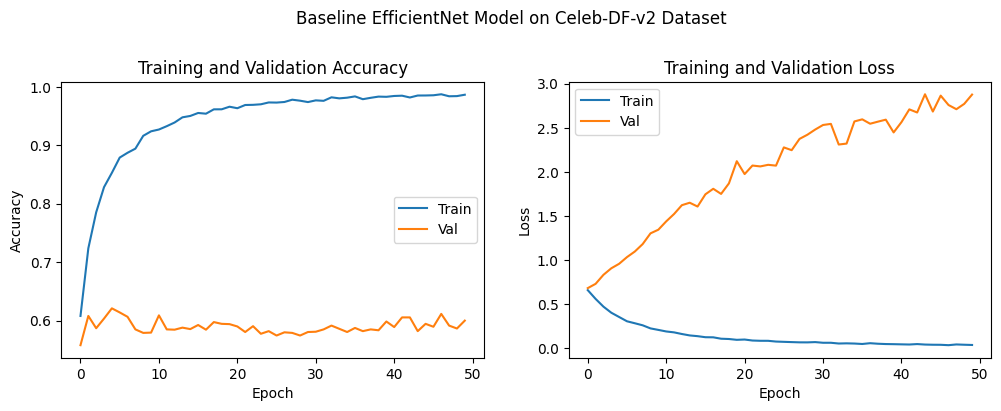

In [17]:
plot_train_result(
    baseline_efficientnet_cdf_history.history,
    title="Baseline EfficientNet Model on Celeb-DF-v2 Dataset"
)

In [18]:
save_model_and_history(
    baseline_efficientnet_cdf_model, baseline_efficientnet_cdf_history, "baseline_efficientnet_cdf"
)

Model saved at baseline_efficientnet_cdf_model.keras
Training history saved at baseline_efficientnet_cdf_history.pkl


#### DeeperForensics-1.0 Dataset

In [19]:
baseline_efficientnet_df_model = create_efficientnet_model(best_hp)
baseline_efficientnet_df_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb7 (Functional)     │ ?                      │    64,097,687 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,097,687 (244.51 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 64,097,687 (244.51 MB)

In [20]:
baseline_efficientnet_df_history = baseline_efficientnet_df_model.fit(
    df_train_generator, validation_data=df_val_generator, epochs=NUM_EPOCHS
)

Epoch 1/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 366s 526ms/step - accuracy: 0.7428 - loss: 0.5409 - val_accuracy: 0.7670 - val_loss: 0.4589
Epoch 2/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 38s 87ms/step - accuracy: 0.9443 - loss: 0.1892 - val_accuracy: 0.8210 - val_loss: 0.4520
Epoch 3/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 38s 86ms/step - accuracy: 0.9750 - loss: 0.0990 - val_accuracy: 0.8160 - val_loss: 0.4806
Epoch 4/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 41s 86ms/step - accuracy: 0.9847 - loss: 0.0613 - val_accuracy: 0.7765 - val_loss: 0.5590
Epoch 5/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 38s 86ms/step - accuracy: 0.9876 - loss: 0.0455 - val_accuracy: 0.8120 - val_loss: 0.5059
Epoch 6/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 38s 86ms/step - accuracy: 0.9898 - loss: 0.0356 - val_accuracy: 0.8010 - val_loss: 0.5578
Epoch 7/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 38s 86ms/step - accuracy: 0.9918 - loss: 0.0292 - val_accuracy: 0.8310 - val_loss: 0.4925
Epoch 8/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 38s 86ms/step - accuracy: 0.9933 - loss: 0.0245 

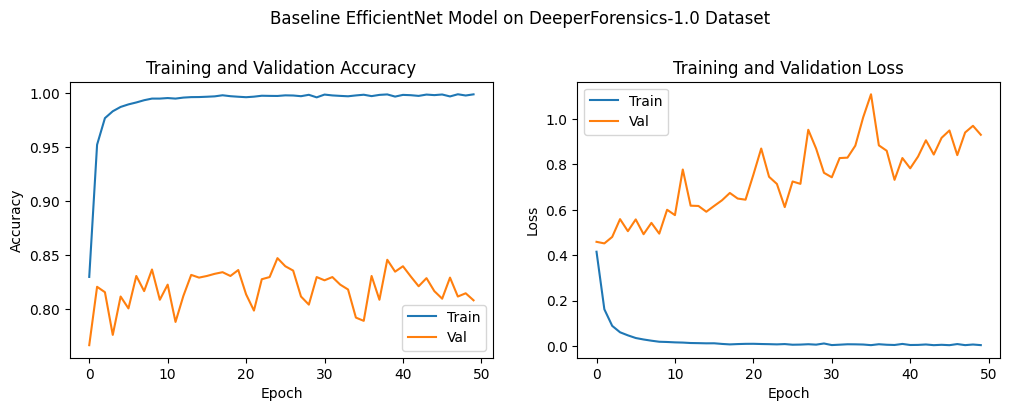

In [21]:
plot_train_result(
    baseline_efficientnet_df_history.history,
    title="Baseline EfficientNet Model on DeeperForensics-1.0 Dataset"
)

In [22]:
save_model_and_history(
    baseline_efficientnet_df_model, baseline_efficientnet_df_history, "baseline_efficientnet_df"
)

Model saved at baseline_efficientnet_df_model.keras
Training history saved at baseline_efficientnet_df_history.pkl


#### DFDC Dataset

In [23]:
baseline_efficientnet_dfdc_model = create_efficientnet_model(best_hp)
baseline_efficientnet_dfdc_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb7 (Functional)     │ ?                      │    64,097,687 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,097,687 (244.51 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 64,097,687 (244.51 MB)

In [24]:
baseline_efficientnet_dfdc_history = baseline_efficientnet_dfdc_model.fit(
    dfdc_train_generator, validation_data=dfdc_val_generator, epochs=NUM_EPOCHS
)

Epoch 1/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 353s 508ms/step - accuracy: 0.5779 - loss: 0.6724 - val_accuracy: 0.4735 - val_loss: 0.7293
Epoch 2/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 37s 85ms/step - accuracy: 0.7579 - loss: 0.5223 - val_accuracy: 0.5910 - val_loss: 0.7651
Epoch 3/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 38s 85ms/step - accuracy: 0.8571 - loss: 0.3669 - val_accuracy: 0.6155 - val_loss: 0.8826
Epoch 4/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 38s 85ms/step - accuracy: 0.9060 - loss: 0.2668 - val_accuracy: 0.5975 - val_loss: 0.9571
Epoch 5/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 41s 85ms/step - accuracy: 0.9237 - loss: 0.2096 - val_accuracy: 0.5715 - val_loss: 1.1086
Epoch 6/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 37s 85ms/step - accuracy: 0.9459 - loss: 0.1620 - val_accuracy: 0.5750 - val_loss: 1.1873
Epoch 7/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 38s 85ms/step - accuracy: 0.9500 - loss: 0.1479 - val_accuracy: 0.5750 - val_loss: 1.1720
Epoch 8/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 37s 85ms/step - accuracy: 0.9531 - loss: 0.1297 

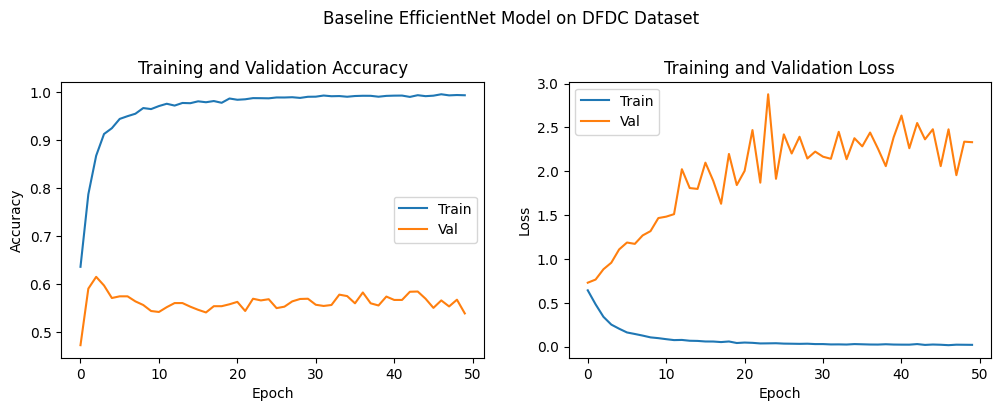

In [25]:
plot_train_result(
    baseline_efficientnet_dfdc_history.history,
    title="Baseline EfficientNet Model on DFDC Dataset"
)

In [26]:
save_model_and_history(
    baseline_efficientnet_dfdc_model, baseline_efficientnet_dfdc_history, "baseline_efficientnet_dfdc"
)

Model saved at baseline_efficientnet_dfdc_model.keras
Training history saved at baseline_efficientnet_dfdc_history.pkl


### Dropout EfficientNet Model Training

#### Celeb-DF-v2 Dataset

In [27]:
dropout_efficientnet_cdf_model = create_efficientnet_model(best_hp, dropout=True)
dropout_efficientnet_cdf_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb7 (Functional)     │ ?                      │    64,097,687 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,097,687 (244.51 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 64,097,687 (244.51 MB)

In [28]:
dropout_efficientnet_cdf_history = dropout_efficientnet_cdf_model.fit(
    cdf_train_generator, validation_data=cdf_val_generator, epochs=NUM_EPOCHS
)

Epoch 1/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 286s 348ms/step - accuracy: 0.5307 - loss: 0.6912 - val_accuracy: 0.5485 - val_loss: 0.6783
Epoch 2/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 49s 85ms/step - accuracy: 0.6200 - loss: 0.6552 - val_accuracy: 0.5710 - val_loss: 0.6720
Epoch 3/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 38s 85ms/step - accuracy: 0.6926 - loss: 0.5891 - val_accuracy: 0.5830 - val_loss: 0.6986
Epoch 4/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 38s 85ms/step - accuracy: 0.7499 - loss: 0.5333 - val_accuracy: 0.5935 - val_loss: 0.7519
Epoch 5/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 38s 85ms/step - accuracy: 0.7953 - loss: 0.4641 - val_accuracy: 0.5845 - val_loss: 0.8055
Epoch 6/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 38s 86ms/step - accuracy: 0.8160 - loss: 0.4189 - val_accuracy: 0.6060 - val_loss: 0.8537
Epoch 7/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 38s 85ms/step - accuracy: 0.8378 - loss: 0.3829 - val_accuracy: 0.6030 - val_loss: 0.8914
Epoch 8/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 38s 85ms/step - accuracy: 0.8659 - loss: 0.3315 

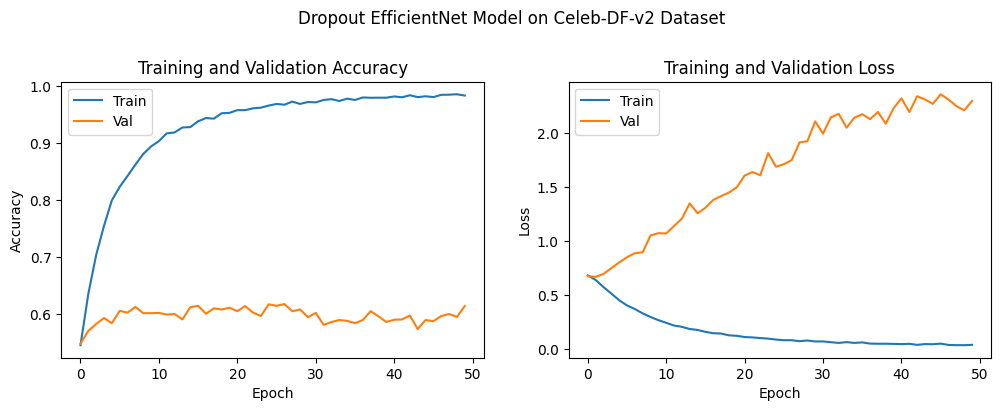

In [29]:
plot_train_result(
    dropout_efficientnet_cdf_history.history,
    title="Dropout EfficientNet Model on Celeb-DF-v2 Dataset"
)

In [30]:
save_model_and_history(
    dropout_efficientnet_cdf_model, dropout_efficientnet_cdf_history, "dropout_efficientnet_cdf"
)

Model saved at dropout_efficientnet_cdf_model.keras
Training history saved at dropout_efficientnet_cdf_history.pkl


#### DeeperForensics-1.0 Dataset

In [31]:
dropout_efficientnet_df_model = create_efficientnet_model(best_hp, dropout=True)
dropout_efficientnet_df_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb7 (Functional)     │ ?                      │    64,097,687 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,097,687 (244.51 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 64,097,687 (244.51 MB)

In [32]:
dropout_efficientnet_df_history = dropout_efficientnet_df_model.fit(
    df_train_generator, validation_data=df_val_generator, epochs=NUM_EPOCHS
)

Epoch 1/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 282s 348ms/step - accuracy: 0.6461 - loss: 0.6162 - val_accuracy: 0.7780 - val_loss: 0.4796
Epoch 2/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 37s 84ms/step - accuracy: 0.9099 - loss: 0.2722 - val_accuracy: 0.8135 - val_loss: 0.4300
Epoch 3/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 37s 84ms/step - accuracy: 0.9539 - loss: 0.1444 - val_accuracy: 0.8210 - val_loss: 0.4436
Epoch 4/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 37s 84ms/step - accuracy: 0.9701 - loss: 0.0961 - val_accuracy: 0.8435 - val_loss: 0.4035
Epoch 5/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 38s 85ms/step - accuracy: 0.9786 - loss: 0.0679 - val_accuracy: 0.8025 - val_loss: 0.4918
Epoch 6/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 38s 85ms/step - accuracy: 0.9862 - loss: 0.0508 - val_accuracy: 0.8040 - val_loss: 0.5299
Epoch 7/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 38s 85ms/step - accuracy: 0.9883 - loss: 0.0433 - val_accuracy: 0.8540 - val_loss: 0.3959
Epoch 8/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 38s 85ms/step - accuracy: 0.9910 - loss: 0.0342 

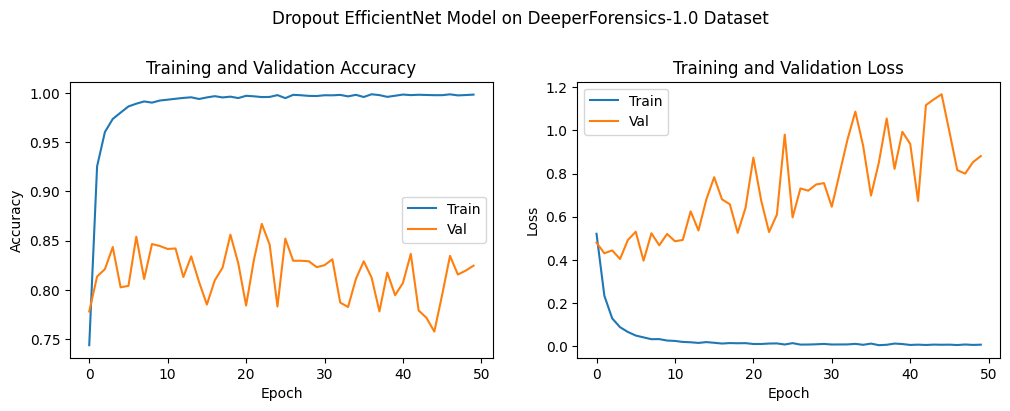

In [33]:
plot_train_result(
    dropout_efficientnet_df_history.history,
    title="Dropout EfficientNet Model on DeeperForensics-1.0 Dataset"
)

In [34]:
save_model_and_history(
    dropout_efficientnet_df_model, dropout_efficientnet_df_history, "dropout_efficientnet_df"
)

Model saved at dropout_efficientnet_df_model.keras
Training history saved at dropout_efficientnet_df_history.pkl


#### DFDC Dataset

In [35]:
dropout_efficientnet_dfdc_model = create_efficientnet_model(best_hp, dropout=True)
dropout_efficientnet_dfdc_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb7 (Functional)     │ ?                      │    64,097,687 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,097,687 (244.51 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 64,097,687 (244.51 MB)

In [36]:
dropout_efficientnet_dfdc_history = dropout_efficientnet_dfdc_model.fit(
    dfdc_train_generator, validation_data=dfdc_val_generator, epochs=NUM_EPOCHS
)

Epoch 1/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 277s 334ms/step - accuracy: 0.5344 - loss: 0.6892 - val_accuracy: 0.5535 - val_loss: 0.6866
Epoch 2/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 37s 83ms/step - accuracy: 0.6572 - loss: 0.6305 - val_accuracy: 0.6055 - val_loss: 0.6941
Epoch 3/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 36s 82ms/step - accuracy: 0.7603 - loss: 0.5224 - val_accuracy: 0.6070 - val_loss: 0.7401
Epoch 4/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 41s 83ms/step - accuracy: 0.8363 - loss: 0.3989 - val_accuracy: 0.5790 - val_loss: 0.8435
Epoch 5/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 36s 82ms/step - accuracy: 0.8707 - loss: 0.3172 - val_accuracy: 0.5805 - val_loss: 0.8339
Epoch 6/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 37s 83ms/step - accuracy: 0.9023 - loss: 0.2514 - val_accuracy: 0.5755 - val_loss: 0.9337
Epoch 7/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 36s 82ms/step - accuracy: 0.9160 - loss: 0.2190 - val_accuracy: 0.5600 - val_loss: 0.9840
Epoch 8/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 41s 83ms/step - accuracy: 0.9351 - loss: 0.1781 

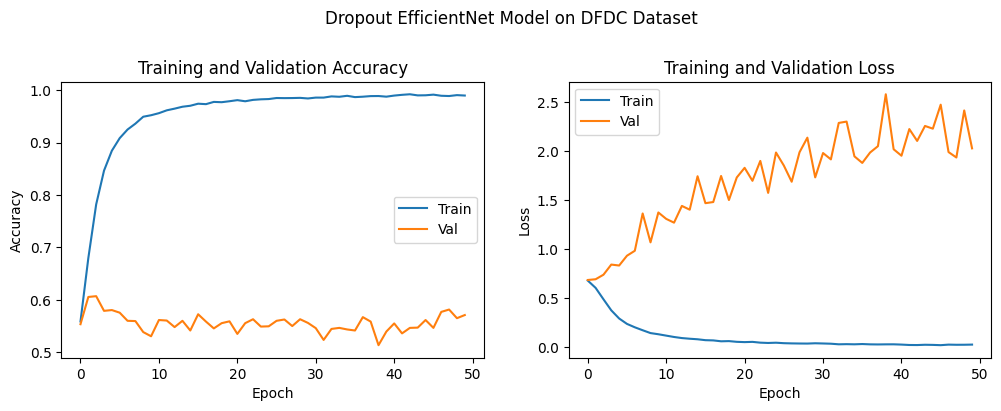

In [37]:
plot_train_result(
    dropout_efficientnet_dfdc_history.history,
    title="Dropout EfficientNet Model on DFDC Dataset"
)

In [38]:
save_model_and_history(
    dropout_efficientnet_dfdc_model, dropout_efficientnet_dfdc_history, "dropout_efficientnet_dfdc"
)

Model saved at dropout_efficientnet_dfdc_model.keras
Training history saved at dropout_efficientnet_dfdc_history.pkl
